## Биоинформатика для высокопроизводительного секвенирования
## Домашнее задание № 7 "Рибосомный профайлинг"
#### Студент: Рогова Полина
#### Группа: мАДБМ19

In [2]:
options(warn = -1)
library('ggplot2')
library('dplyr')
library('tidyr')
library('edgeR')
library('EnhancedVolcano')
library('ape')
library('png')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma

Loading required package: ggrepel



##### Задание 1. Определение дифференциальной экспрессии

В папке курса на Google Drive хранится файл 0​ 1. RiboSeq_RNASeq_HCC_counts.tsv,​в котором содержится матрица каунтов результатов Ribo-Seq и RNA-Seq экспериментов больных гепатоцеллюлярной карциномой. Матрица каунтов была получена стандартным воркфлоу STAR. На каждого пациента приходится 4 столбца в таблице (RNA-Seq нормы и опухоли, Ribo-Seq нормы и опухоли), записанные в виде ​sample_number-tissue_type-experiment.​


In [2]:
data <- read.csv('/users/vraip/Anaconda/ngs/hw_riboseq/01. RiboSeq_RNASeq_HCC_counts.tsv', sep = '\t')
head(data)

,geneID,geneSymbol,LC001.normal.RPF,LC001.tumor.RPF,LC001.normal.RNA,LC001.tumor.RNA,LC033.normal.RPF,LC033.tumor.RPF,LC033.normal.RNA,LC033.tumor.RNA,⋯,LC507.normal.RNA,LC507.tumor.RNA,LC508.normal.RPF,LC508.tumor.RPF,LC508.normal.RNA,LC508.tumor.RNA,LC509.normal.RPF,LC509.tumor.RPF,LC509.normal.RNA,LC509.tumor.RNA
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSG00000000003.14,TSPAN6,0,0,402,873,0,0,301,1627,⋯,218,457,0,0,200,889,0,0,161,857
2,ENSG00000000005.5,TNMD,0,0,0,1,0,0,0,1,⋯,0,0,1,0,0,0,0,0,0,NA
3,ENSG00000000419.12,DPM1,168,239,88,187,114,439,66,201,⋯,92,170,109,357,60,244,141,173,56,83
4,ENSG00000000457.13,SCYL3,65,121,60,106,36,163,70,156,⋯,127,176,67,176,55,261,64,100,68,176
5,ENSG00000000460.16,C1orf112,8,43,18,70,16,76,4,63,⋯,124,437,7,167,34,201,6,61,9,58
6,ENSG00000000938.12,FGR,0,6,19,9,14,13,61,24,⋯,94,13,3,9,42,26,7,10,26,57


In [3]:
table(endsWith(colnames(data), 'RNA'))


FALSE  TRUE 
   22    20 

In [3]:
expr_RNA <- data[, endsWith(colnames(data), 'RNA')]
row.names(expr_RNA) <- data$geneID
head(expr_RNA)

,LC001.normal.RNA,LC001.tumor.RNA,LC033.normal.RNA,LC033.tumor.RNA,LC034.normal.RNA,LC034.tumor.RNA,LC501.normal.RNA,LC501.tumor.RNA,LC502.normal.RNA,LC502.tumor.RNA,LC505.normal.RNA,LC505.tumor.RNA,LC506.normal.RNA,LC506.tumor.RNA,LC507.normal.RNA,LC507.tumor.RNA,LC508.normal.RNA,LC508.tumor.RNA,LC509.normal.RNA,LC509.tumor.RNA
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003.14,402,873,301,1627,258,65,226,353,208,399,153,361,157,333,218,457,200,889,161,857
ENSG00000000005.5,0,1,0,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,NA
ENSG00000000419.12,88,187,66,201,80,16,54,165,57,174,61,155,104,114,92,170,60,244,56,83
ENSG00000000457.13,60,106,70,156,77,67,78,68,97,128,76,185,114,74,127,176,55,261,68,176
ENSG00000000460.16,18,70,4,63,60,4,17,112,28,14,8,118,25,98,124,437,34,201,9,58
ENSG00000000938.12,19,9,61,24,106,57,60,9,65,36,16,66,64,32,94,13,42,26,26,57


In [4]:
expr_RPF <- data[, endsWith(colnames(data), 'RPF')]
row.names(expr_RPF) <- data$geneID
head(expr_RPF)

,LC001.normal.RPF,LC001.tumor.RPF,LC033.normal.RPF,LC033.tumor.RPF,LC034.normal.RPF,LC034.tumor.RPF,LC501.normal.RPF,LC501.tumor.RPF,LC502.normal.RPF,LC502.tumor.RPF,LC505.normal.RPF,LC505.tumor.RPF,LC506.normal.RPF,LC506.tumor.RPF,LC507.normal.RPF,LC507.tumor.RPF,LC508.normal.RPF,LC508.tumor.RPF,LC509.normal.RPF,LC509.tumor.RPF
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003.14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000000005.5,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0
ENSG00000000419.12,168,239,114,439,325,117,106,192,118,292,159,237,149,230,169,260,109,357,141,173
ENSG00000000457.13,65,121,36,163,130,76,34,43,84,221,74,185,65,98,81,105,67,176,64,100
ENSG00000000460.16,8,43,16,76,44,14,5,27,24,42,10,71,18,103,79,225,7,167,6,61
ENSG00000000938.12,0,6,14,13,15,62,5,5,22,5,0,4,18,6,8,1,3,9,7,10


1. Для каждого гена найдите коэффициент корреляции числа каунтов между экспериментами RNA-Seq и Ribo-Seq. Какую корреляцию вы выберете — Пирсона или Спирмена? Обратите внимание, что перед вами не нормированные каунты.

In [7]:
cors <- sapply(rownames(expr_RNA), function(x) {
    cor(x = as.numeric(expr_RNA[x,]), y = as.numeric(expr_RPF[x,]), method = "spearman")
})

In [8]:
cors <- data.frame(cc = cors)
cors['geneSymbol'] <- data$geneSymbol[rownames(cors) == data$geneID]
head(cors)

,cc,geneSymbol
,<dbl>,<chr>
ENSG00000000003.14,NA,TSPAN6
ENSG00000000005.5,NA,TNMD
ENSG00000000419.12,0.8496241,DPM1
ENSG00000000457.13,0.6977795,SCYL3
ENSG00000000460.16,0.8115834,C1orf112
ENSG00000000938.12,0.5186725,FGR


In [9]:
str(cors)

'data.frame':	18945 obs. of  2 variables:
 $ cc        : num  NA NA 0.85 0.698 0.812 ...
 $ geneSymbol: chr  "TSPAN6" "TNMD" "DPM1" "SCYL3" ...


In [10]:
cors <- cors %>% drop_na()
str(cors)

'data.frame':	15676 obs. of  2 variables:
 $ cc        : num  0.85 0.698 0.812 0.519 0.761 ...
 $ geneSymbol: chr  "DPM1" "SCYL3" "C1orf112" "FGR" ...


2. Постройте гистограмму распределения этих коэффициентов корреляции. Для каких генов корреляция самая высокая, а для каких — самая низкая? Как вы можете это объяснить?

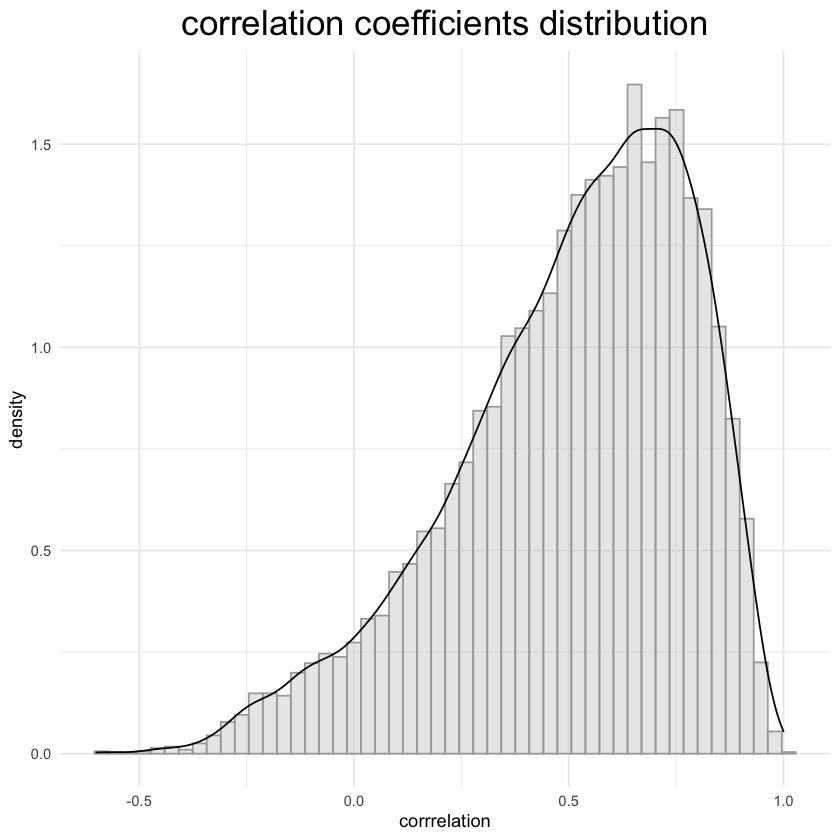

In [12]:
ggplot(cors, aes(x = cc)) +
geom_histogram(aes(y =..density..), position = "identity", alpha = 0.5, bins = 50, 
               fill = 'lightgray', color = 'darkgray') + geom_density(alpha = 0.6) +
labs(title = 'correlation coefficients distribution', x = 'corrrelation', y = 'density') + 
theme_minimal() + theme(plot.title = element_text(size = 21, hjust = 0.5))

In [16]:
ordered_cors <- cors %>% arrange(desc(abs(cc)))

In [23]:
print('гены с самой высокой корреляцией: ')
print(ordered_cors[1:10,])

print('гены с самой низкой корреляцией: ')
print(ordered_cors[(nrow(ordered_cors) - 10):nrow(ordered_cors),])

[1] "гены с самой высокой корреляцией"
                          cc geneSymbol
ENSG00000251258.1  1.0000000     RFPL4B
ENSG00000174016.11 1.0000000     FAM46D
ENSG00000116690.12 0.9909774       PRG4
ENSG00000171747.8  0.9819416     LGALS4
ENSG00000167910.3  0.9808199     CYP7A1
ENSG00000261701.6  0.9804511        HPR
ENSG00000156510.12 0.9800528      HKDC1
ENSG00000171564.11 0.9759398        FGB
ENSG00000157131.10 0.9729323        C8A
ENSG00000162267.12 0.9729323      ITIH3
[1] ""
[1] "гены с самой низкой корреляцией"
                              cc geneSymbol
ENSG00000153443.12  0.0007538649     UBALD1
ENSG00000132600.16  0.0007521625      PRMT7
ENSG00000251192.7  -0.0003816795     ZNF674
ENSG00000100242.15  0.0000000000       SUN2
ENSG00000139675.11  0.0000000000  HNRNPA1L2
ENSG00000141391.13  0.0000000000   PRELID3A
ENSG00000154479.12  0.0000000000    CCDC173
ENSG00000165300.7   0.0000000000    SLITRK5
ENSG00000198353.7   0.0000000000      HOXC4
ENSG00000204172.12  0.0000000000    

3. Найдите дифференциально экспрессированные гены по RNA-Seq между нормой и опухолью. Постройте volcano plot. То же самое сделайте и для Ribo-Seq эксперимента. Совпадают ли результаты дифференциальной экспрессии? Какие гены оказались значимо различны по экспрессии в одном случае, а какие — в другом? Выводы подкрепите графиками.

       tissuestumor
Down           1991
NotSig        11520
Up             2746


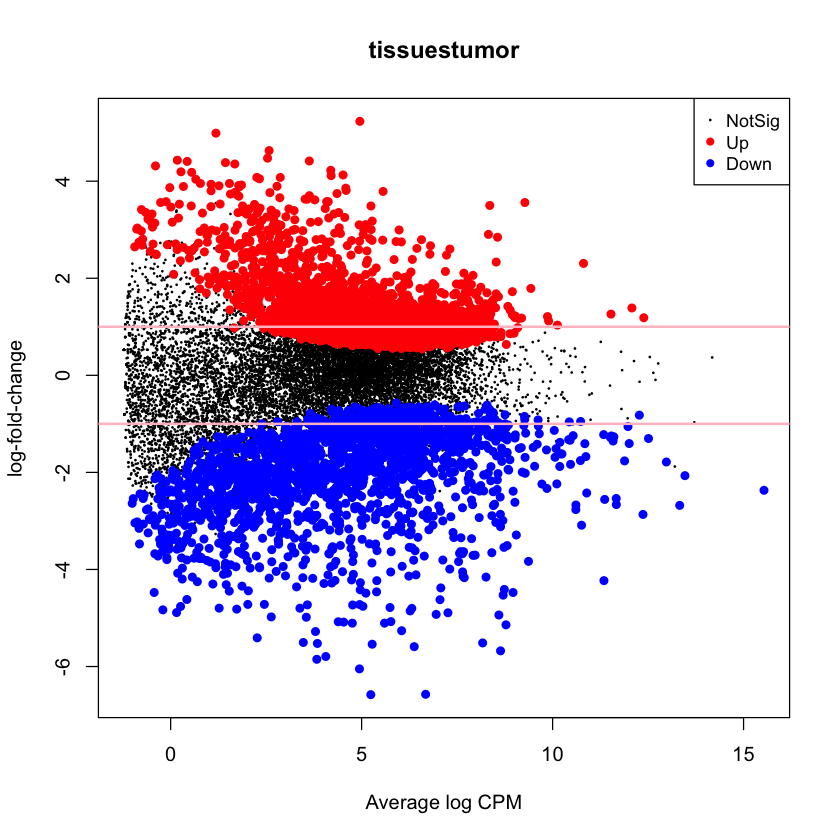

In [5]:
get_dif_expr <- function(df, ...) {
    splts <- strsplit(colnames(df), split = '.', fixed = TRUE)
    patients <- factor(t(data.frame(splts))[, 1])
    tissues <- factor(t(data.frame(splts))[, 2])
    
    design <- model.matrix(~ patients + tissues)
    rownames(design) <- colnames(df)
    
    df <- df %>% drop_na()
    y <- DGEList(genes = row.names(df), counts = df)
    y <- estimateDisp(y, design, robust = TRUE)

    lrt <- glmLRT(glmFit(y, design))
    print(summary(decideTests(lrt)))

    plotMD(lrt)
    abline(h = c(-1, 1), ...)

    return(list('y' = y, 'lrt' = lrt))
}

rna_output <- get_dif_expr(expr_RNA, col = 'pink', lwd = 2)

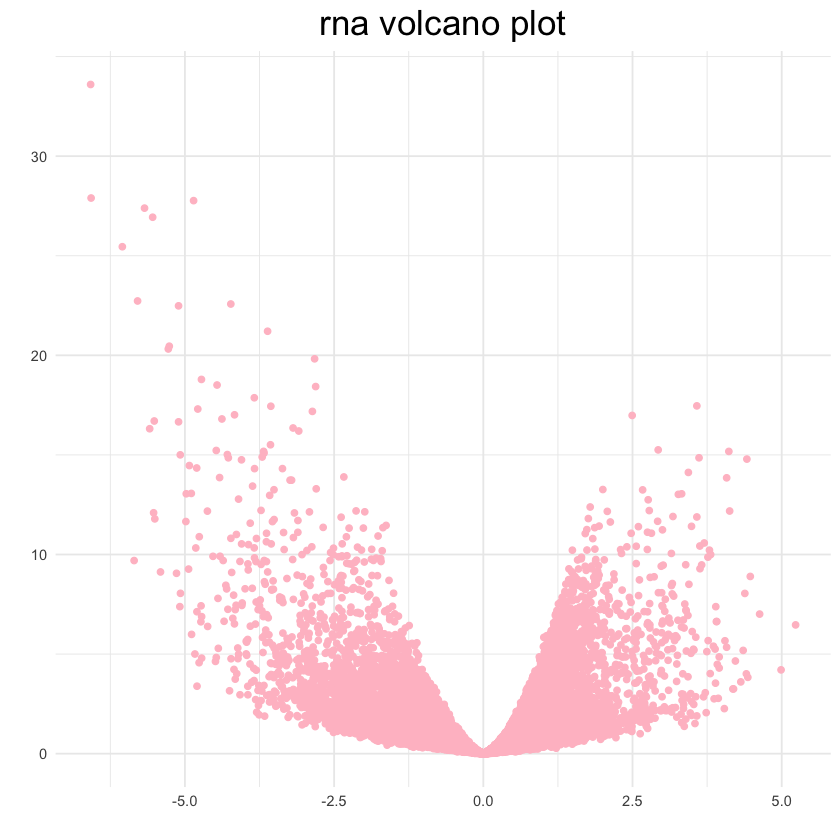

In [6]:
ggplot(data %>% drop_na(), 
       aes(x = rna_output[[2]]$table$logFC, y = -log10(rna_output[[2]]$table$PValue))) + 
geom_point(color = 'pink') +
labs(title = 'RNA-Seq volcano plot', x = '', y = '') + 
theme_minimal() + theme(plot.title = element_text(size = 21, hjust = 0.5))

       tissuestumor
Down            554
NotSig        11739
Up             6652


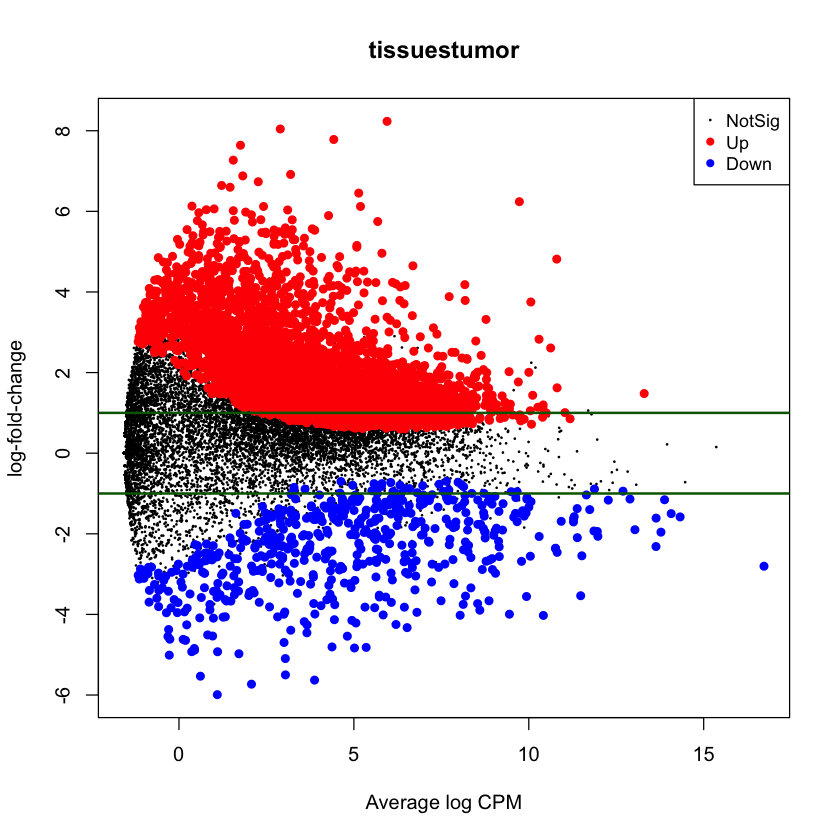

In [7]:
rpf_output <- get_dif_expr(expr_RPF, col = 'darkgreen', lwd = 2)

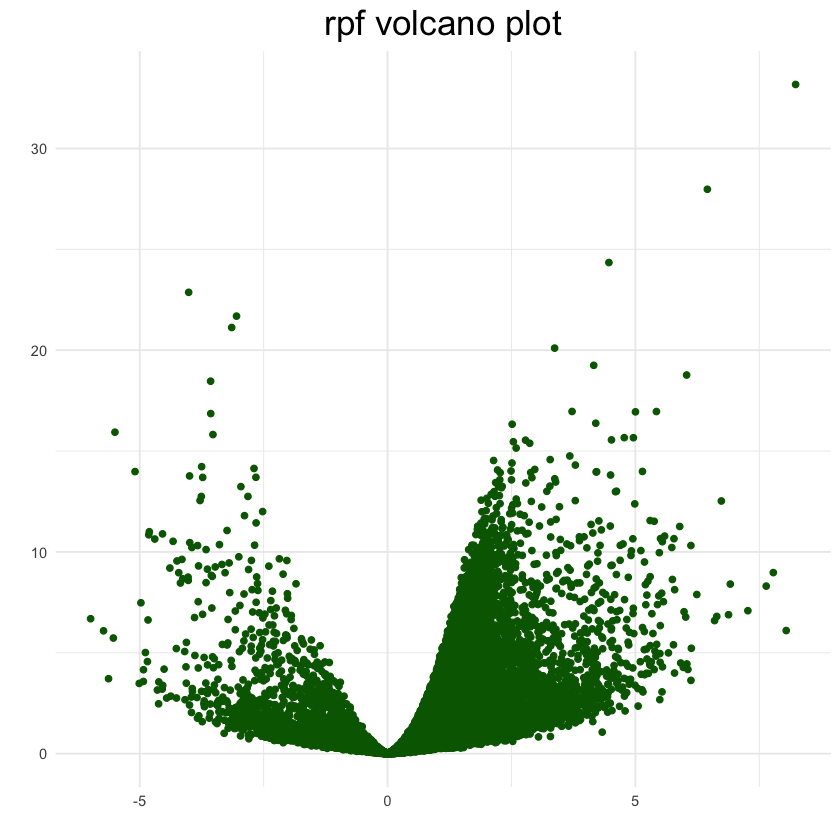

In [8]:
ggplot(data, aes(x = rpf_output[[2]]$table$logFC, y = -log10(rpf_output[[2]]$table$PValue))) + 
geom_point(color = 'darkgreen') +
labs(title = 'Ribo-Seq volcano plot', x = '', y = '') + 
theme_minimal() + theme(plot.title = element_text(size = 21, hjust = 0.5))

In [9]:
print(paste0('RNA common disp = ', rna_output[[1]]$common.dispersion, 
             '; RPF common disp = ', rpf_output[[1]]$common.dispersion))

[1] "RNA common disp = 0.362707919338735; RPF common disp = 0.487140947686983"


In [26]:
# наиболее дифференциально экспрессированные гены по RNA-Seq
toptags <- topTags(rna_output[[2]])$table[-1]
toptags['geneSymbol'] <- data$geneSymbol[data$geneID %in% rownames(toptags)]
toptags

,logFC,logCPM,LR,PValue,FDR,geneSymbol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000182566.12,-6.579886,5.239945,149.25674,2.520121e-34,4.096960e-30,IGFALS
ENSG00000129965.13,-6.572136,6.675129,123.19222,1.265730e-28,9.268536e-25,CHRNA4
ENSG00000099769.5,-4.854625,6.270801,122.59488,1.710378e-28,9.268536e-25,CLEC4M
ENSG00000197408.8,-5.676881,8.636834,120.87462,4.070622e-28,1.654402e-24,INS-IGF2
ENSG00000198077.10,-5.540500,5.275878,118.78833,1.165234e-27,3.788643e-24,GLS2
ENSG00000160339.15,-6.048726,4.942687,112.02476,3.528753e-26,9.561155e-23,OIT3
ENSG00000104938.16,-5.793199,4.061209,99.59980,1.865232e-23,4.331867e-20,FCN2
ENSG00000138315.12,-4.230962,5.396855,98.90326,2.651422e-23,5.388021e-20,CLEC4G
ENSG00000101204.15,-5.106675,4.755127,98.48453,3.275737e-23,5.917072e-20,CYP2B6


In [12]:
cpm(rna_output[[1]])[order(rna_output[[2]]$table$PValue)[1:10],]

,LC001.normal.RNA,LC001.tumor.RNA,LC033.normal.RNA,LC033.tumor.RNA,LC034.normal.RNA,LC034.tumor.RNA,LC501.normal.RNA,LC501.tumor.RNA,LC502.normal.RNA,LC502.tumor.RNA,LC505.normal.RNA,LC505.tumor.RNA,LC506.normal.RNA,LC506.tumor.RNA,LC507.normal.RNA,LC507.tumor.RNA,LC508.normal.RNA,LC508.tumor.RNA,LC509.normal.RNA,LC509.tumor.RNA
ENSG00000182566.12,80.53057,0.8244230,68.51938,0.5357176,77.24638,0.9295705,69.36259,0.4240656,99.99961,0.0000000,108.10426,0.808691,70.57526,7.906833,47.148481,0.7767043,46.79039,0.3263183,67.04292,0.7017098
ENSG00000129965.13,160.83557,0.4122115,114.02054,0.8928627,178.12339,4.0281387,182.44316,0.4240656,214.60821,0.1291871,348.11813,8.491256,216.34286,24.552796,95.135157,1.5534086,224.35992,2.1210690,257.25065,2.9822667
ENSG00000099769.5,253.32166,4.5343267,22.48292,1.4285804,114.77739,0.6197136,94.03027,1.0601641,213.78517,6.3301687,196.88419,30.325913,115.64669,12.692547,43.167054,1.1650565,209.38699,4.5684563,199.91530,10.8765022
ENSG00000197408.8,482.95786,1.6488461,333.76435,5.1786038,596.12755,9.6055616,887.05963,69.1226994,719.33875,37.5934507,500.47233,15.971647,1371.49058,130.462737,340.307257,5.0485780,1005.05757,8.1579576,1427.31638,7.3679531
ENSG00000198077.10,26.16680,0.2061058,81.63442,0.1785725,21.64487,0.6197136,64.96637,7.4211487,78.39476,1.9378067,184.00130,14.556438,155.66132,2.913044,12.992026,0.3883522,64.57074,0.4894775,48.84122,0.3508549
ENSG00000160339.15,105.79507,1.0305288,51.65719,1.0714353,50.43851,1.8591409,36.87941,0.2120328,63.16848,0.0000000,89.05999,0.808691,74.97247,8.531056,32.899162,1.1650565,40.94159,0.0000000,46.41433,0.8771373
ENSG00000104938.16,25.26449,0.6183173,25.96242,0.5357176,33.36090,0.3098568,26.13309,0.6360985,60.69935,0.0000000,63.85433,0.808691,34.95784,2.913044,4.610074,0.0000000,23.86310,0.0000000,20.62859,1.4034196
ENSG00000138315.12,98.57664,2.8854806,77.88727,1.2500078,107.23147,9.9154184,84.50513,2.7564267,100.20537,1.4210583,91.58055,6.873874,69.03624,17.062112,37.928333,1.1650565,60.35960,4.7316154,52.78492,7.0170982
ENSG00000101204.15,103.08816,0.6183173,32.92142,1.4285804,69.70046,5.2675660,14.65407,0.2120328,32.09864,1.9378067,85.97930,14.354265,75.41219,1.248447,5.657818,0.1941761,45.15273,0.3263183,42.16726,0.3508549
ENSG00000135423.12,187.22794,14.8396147,87.79046,2.5000156,189.64084,16.7322685,159.48511,20.3551507,140.12291,20.4115643,284.26380,22.239003,178.30697,12.900622,47.567578,0.5825282,98.25982,6.8526844,139.54634,51.7510993


In [25]:
# наиболее дифференциально экспрессированные гены по Ribo-Seq
toptags <- topTags(rpf_output[[2]])$table[-1]
toptags['geneSymbol'] <- data$geneSymbol[data$geneID %in% rownames(toptags)]
toptags

,logFC,logCPM,LR,PValue,FDR,geneSymbol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000112818.9,8.233164,5.948788,147.30096,6.744356e-34,1.277718e-29,MEP1A
ENSG00000163993.6,6.452498,5.138570,123.55046,1.056649e-28,1.000911e-24,GHR
ENSG00000134057.14,4.466023,5.022013,106.96818,4.523740e-25,2.856742e-21,HAO2
ENSG00000145708.10,-4.012997,5.837200,100.23740,1.351823e-23,6.402570e-20,TOP2A
ENSG00000112964.13,-3.047595,6.766920,94.85322,2.050385e-22,7.768909e-19,CCNB1
ENSG00000135423.12,-3.145183,6.100496,92.28466,7.506400e-22,2.370146e-18,GLS2
ENSG00000225697.10,3.371194,4.301160,87.62854,7.897690e-21,2.137454e-17,IGF2BP3
ENSG00000131747.14,4.159764,6.465874,83.74571,5.626894e-20,1.332519e-16,CRHBP
ENSG00000136231.13,6.034190,3.107460,81.55788,1.702033e-19,3.582780e-16,S100P


In [14]:
cpm(rpf_output[[1]])[order(rpf_output[[2]]$table$PValue)[1:10],]

,LC001.normal.RPF,LC001.tumor.RPF,LC033.normal.RPF,LC033.tumor.RPF,LC034.normal.RPF,LC034.tumor.RPF,LC501.normal.RPF,LC501.tumor.RPF,LC502.normal.RPF,LC502.tumor.RPF,LC505.normal.RPF,LC505.tumor.RPF,LC506.normal.RPF,LC506.tumor.RPF,LC507.normal.RPF,LC507.tumor.RPF,LC508.normal.RPF,LC508.tumor.RPF,LC509.normal.RPF,LC509.tumor.RPF
ENSG00000112818.9,2.1375651,353.755718,0.0000000,2.1277847,0.0000000,14.102392,0.0000000,0.000000,0.0000000,0.3917888,0.0000000,0.4146045,0.0000000,0.00000,0.0000000,0.000000,0.4100911,337.2298743,1.3596264,516.80317
ENSG00000163993.6,0.3562609,19.731395,0.2095199,29.4530194,0.7236944,420.427549,0.3893369,14.040186,3.9889160,159.2621364,0.1749528,38.1436165,0.0000000,7.67502,0.2103618,4.268257,0.0000000,0.4340153,0.0000000,0.00000
ENSG00000134057.14,2.1375651,57.549901,1.0475994,28.3331327,3.6988824,66.692560,1.9466846,26.475779,0.9702769,12.5372407,0.1749528,19.9010173,6.7159351,93.03055,25.4537767,111.727916,1.4353189,117.6181415,0.9711617,65.54209
ENSG00000145708.10,91.2027794,3.993258,41.0658946,1.5678413,132.4360702,9.989194,116.4117386,8.624686,52.5027591,2.4486798,96.3990156,9.3286019,136.5573470,31.86296,126.6377980,2.008592,158.9103059,3.3274505,93.6199918,17.70390
ENSG00000112964.13,340.4072489,30.066887,48.3990901,4.3675580,119.0075191,4.700797,419.8998664,45.329743,115.3551380,28.3067389,112.6696299,22.5959467,344.5025967,41.39859,42.7034435,9.540811,216.7331527,26.7642757,179.8591544,18.83393
ENSG00000135423.12,148.0263861,25.368936,61.5988419,4.2555693,142.9698439,4.700797,166.6362011,28.682094,80.9642137,18.1202308,241.2599684,17.2060879,130.0901502,17.90838,53.0111713,3.766110,55.3623001,6.5102292,131.4952997,27.30921
ENSG00000225697.10,2.8500869,78.925579,3.5618378,63.7215514,1.4473887,29.379982,2.3360215,17.249371,3.4498733,22.3319601,1.3996227,14.3038562,3.4823367,48.37588,9.6766424,42.682575,2.0504556,11.7184126,2.9134852,26.17917
ENSG00000131747.14,3.3844781,61.073364,8.7998346,68.9850187,6.1916074,201.546680,6.0347222,89.255467,4.2045331,28.2087917,1.9244813,66.9586312,13.9293469,371.88961,60.5841957,142.358940,9.2270500,367.6109441,3.6904146,245.97119
ENSG00000136231.13,0.0000000,11.744878,0.0000000,0.1119887,0.1608210,27.617184,0.0000000,1.604593,0.0000000,0.0000000,0.1749528,9.3286019,0.4974767,43.49178,1.4725325,33.894986,0.4100911,7.8122751,0.0000000,29.00426
ENSG00000116882.14,114.1816047,5.402644,94.9125014,12.7667080,115.6302787,8.226395,92.6621866,16.447075,87.0014920,1.8609967,96.7489213,25.2908762,120.3893551,34.18873,47.9624883,1.757518,116.2608302,5.7868704,187.2399836,11.30036


В целом, дифференциаьно экспрессируемые гены между экспериментами не особо совпадают, что порядок p-value у значимых генов ощутимо различается. Наилучшим вариантом будет изучать гены на пересечении, оказавшиеся значимыми в обоих экспериментах.


##### Задание 2. Анализ wig-файла
В папке курса на Google Drive хранятся два файла с .wig-трэками Ribo-Seq эксперимента кишечной палочки: ​02. RiboSeq_EColi_track_f.wig​и 0​ 2. RiboSeq_EColi_track_r.wig для прямой и обратной цепочек соответственно. Трэки эти были получены следующим образом: сначала прочтения прошли QC, адаптеры были удалены, а получившиеся “чистые” риды были откартированы на геном кишечной палочки. Затем каждой геномной позиции были присвоены значения, соответствующие числу 3’-концов прочтений, был определён оффсет для определения P-сайта, после чего скорректированные на этот оффсет значения и были записаны в wig-файл. Референсный геном, использовавшийся в ходе обработки прочтений, — U​ 00096.3.​Для выполнения заданий вам потребуется его аннотация (её вы можете найти в GenBank).

In [3]:
fw_track <- read.csv('/users/vraip/Anaconda/ngs/hw_riboseq/02. RiboSeq_EColi_track_f.wig', 
                     sep = '\t', skip = 1, header = FALSE, col.names = c('position', 'read_counts'))
rv_track <- read.csv('/users/vraip/Anaconda/ngs/hw_riboseq/02. RiboSeq_EColi_track_r.wig', 
                     sep = '\t', skip = 1, header = FALSE, col.names = c('position', 'read_counts'))

In [4]:
rec <- read.GenBank('U00096.3')
print(attr(rec, 'species'))
rec

[1] "Escherichia_coli_str._K-12_substr._MG1655"


1 DNA sequence in binary format stored in a list.

Sequence length: 4641652 

Label:
U00096.3

Base composition:
    a     c     g     t 
0.246 0.254 0.254 0.246 
(Total: 4.64 Mb)

In [5]:
annotation <- read.gff('/users/vraip/Anaconda/ngs/hw_riboseq/sequence.gff3')
features <- annotation[annotation$type == 'CDS', ]
features$start <- as.numeric(features$start)
features$end <- as.numeric(features$end)
features <- features[ , !(names(features) == 'score')]
head(features)

,seqid,source,type,start,end,strand,phase,attributes
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<chr>
3,U00096.3,Genbank,CDS,190,255,+,0,"ID=cds-AAC73112.1;Parent=gene-b0001;Dbxref=UniProtKB/Swiss-Prot:P0AD86,NCBI_GP:AAC73112.1,ASAP:ABE-0000006,ECOCYC:EG11277;Name=AAC73112.1;gbkey=CDS;gene=thrL;locus_tag=b0001;product=thr operon leader peptide;protein_id=AAC73112.1;transl_table=11"
5,U00096.3,Genbank,CDS,337,2799,+,0,"ID=cds-AAC73113.1;Parent=gene-b0002;Dbxref=UniProtKB/Swiss-Prot:P00561,NCBI_GP:AAC73113.1,ASAP:ABE-0000008,ECOCYC:EG10998;Name=AAC73113.1;gbkey=CDS;gene=thrA;locus_tag=b0002;product=fused aspartate kinase/homoserine dehydrogenase 1;protein_id=AAC73113.1;transl_table=11"
7,U00096.3,Genbank,CDS,2801,3733,+,0,"ID=cds-AAC73114.1;Parent=gene-b0003;Dbxref=UniProtKB/Swiss-Prot:P00547,NCBI_GP:AAC73114.1,ASAP:ABE-0000010,ECOCYC:EG10999;Name=AAC73114.1;gbkey=CDS;gene=thrB;locus_tag=b0003;product=homoserine kinase;protein_id=AAC73114.1;transl_table=11"
9,U00096.3,Genbank,CDS,3734,5020,+,0,"ID=cds-AAC73115.1;Parent=gene-b0004;Dbxref=UniProtKB/Swiss-Prot:P00934,NCBI_GP:AAC73115.1,ASAP:ABE-0000012,ECOCYC:EG11000;Name=AAC73115.1;gbkey=CDS;gene=thrC;locus_tag=b0004;product=threonine synthase;protein_id=AAC73115.1;transl_table=11"
11,U00096.3,Genbank,CDS,5234,5530,+,0,"ID=cds-AAC73116.1;Parent=gene-b0005;Dbxref=UniProtKB/Swiss-Prot:P75616,NCBI_GP:AAC73116.1,ASAP:ABE-0000015,ECOCYC:G6081;Name=AAC73116.1;gbkey=CDS;gene=yaaX;locus_tag=b0005;product=DUF2502 domain-containing protein YaaX;protein_id=AAC73116.1;transl_table=11"
13,U00096.3,Genbank,CDS,5683,6459,-,0,"ID=cds-AAC73117.1;Parent=gene-b0006;Dbxref=UniProtKB/Swiss-Prot:P0A8I3,NCBI_GP:AAC73117.1,ASAP:ABE-0000018,ECOCYC:EG10011;Name=AAC73117.1;gbkey=CDS;gene=yaaA;locus_tag=b0006;product=peroxide stress resistance protein YaaA;protein_id=AAC73117.1;transl_table=11"


1. Присутствует ли в покрытии генома неравномерность? Рассмотрите неравномерность покрытия на примере любого выбранного вами гена. Что вы можете сказать про эту неравномерность? Присутствует ли там периодичность в три нуклеотида? А если взять среднее по большому количеству генов (взяв за точку отсчёта старт-кодон)? Выводы проиллюстрируйте графиками.

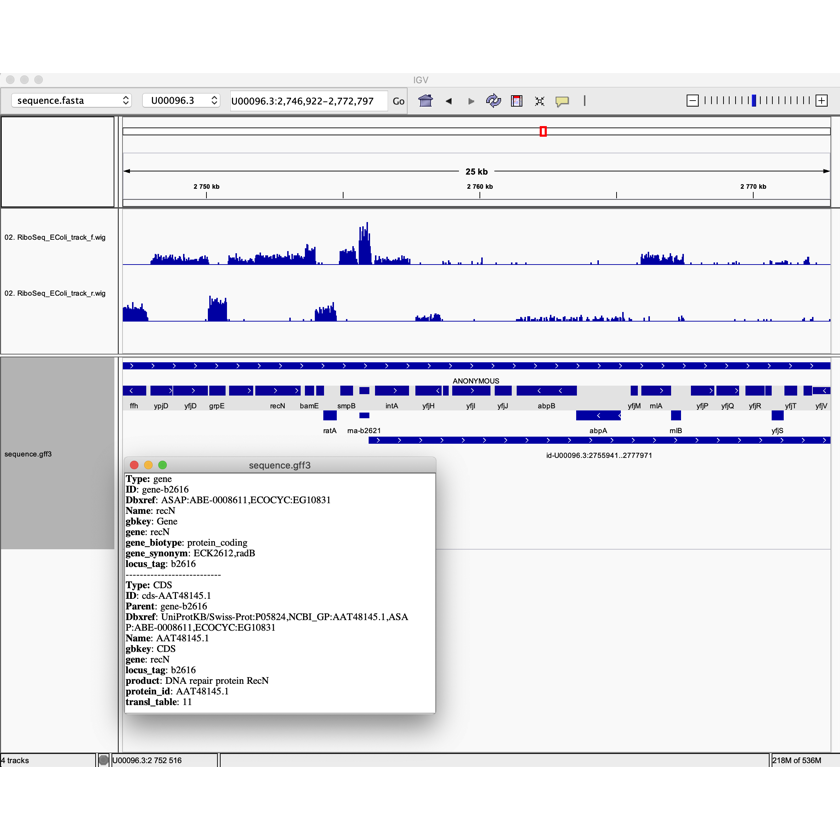

In [5]:
img <- readPNG('/users/vraip/Anaconda/ngs/hw_riboseq/pic1.PNG')
grid::grid.raster(img)

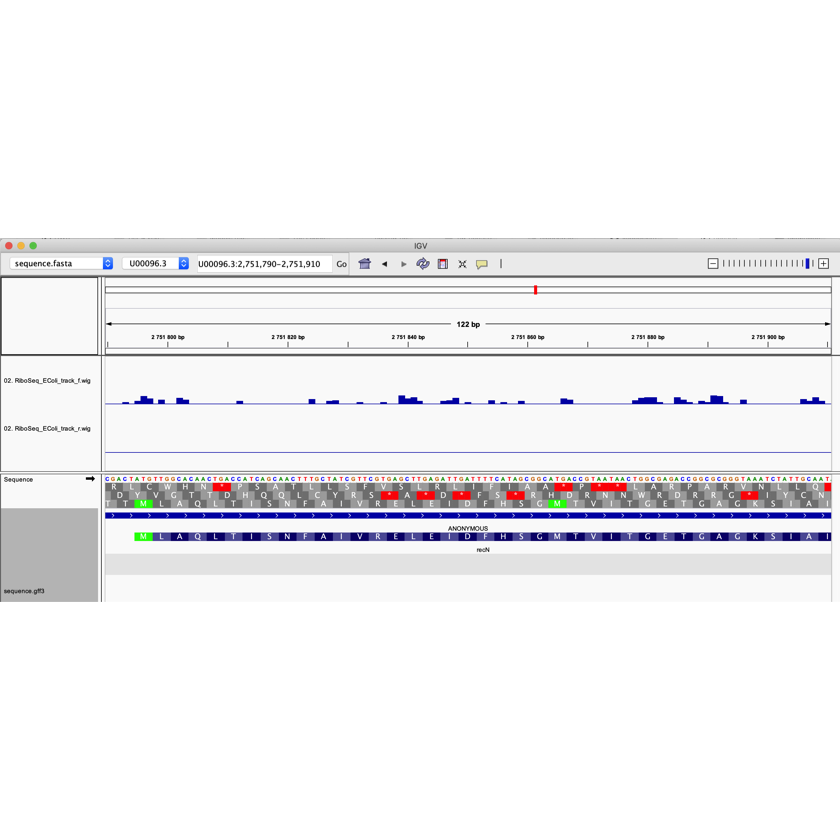

In [6]:
img <- readPNG('/users/vraip/Anaconda/ngs/hw_riboseq/pic2.PNG')
grid::grid.raster(img)

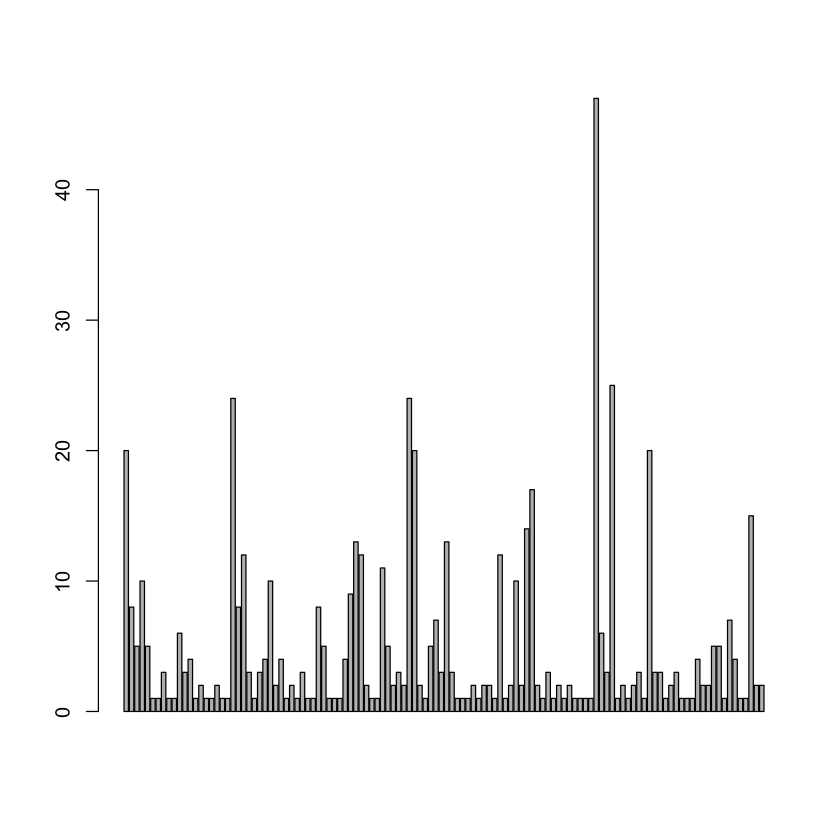

In [5]:
my_gene <- features[which(grepl('recN', features$attributes, fixed = TRUE)), ]
my_gene_cov <- fw_track[fw_track$position > my_gene$start & fw_track$position < my_gene$end, ]
barplot(my_gene_cov$read_counts[1:120])

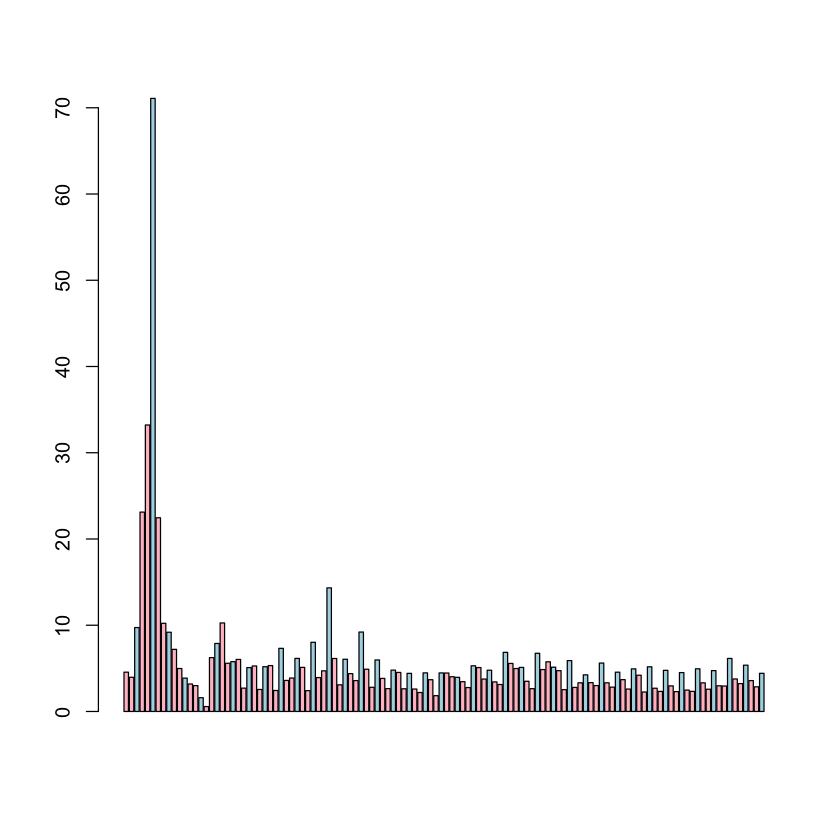

In [6]:
n <- 120
gene_counts <- c()
pos_counts <- t(apply(features, 1, function(x) {
    counts <- if (x["strand"] == 2) fw_track else rv_track    
    counts <- counts[counts$position >= as.numeric(x["start"]) & counts$position <= (as.numeric(x["start"]) + n), ]
    pos_counts <- c()
    for (i in seq(from = x["start"], by = 1, length.out = n)) {
        if (nrow(counts[as.numeric(counts$position) == i,]) > 0) {
            pos_counts <- c(pos_counts, as.numeric(counts[as.numeric(counts$position) == i,]$read_counts))
        } else {
            pos_counts <- c(pos_counts, 0)
        }
    }
    return(pos_counts)
}))
barplot(apply(pos_counts, 2, mean), col = c('pink', 'pink', 'lightblue'))

##### выводы
на графике для одного гена покрытие неравномерное, и нельзя заметить периодичность в 3 нуклеотида, на агрегированном графике, где было рассчитано среднее по всем генам, в принципе можно говорить о наличии периодичности, но все равно какой-то не очень хороший график получился, потому что как минимум самый больший пик вроде должен ожидаться на первом кодоне, а по графику выходит, что он на втором. ВОзможо, какая-то ерунда с координатами в wig-файле.



2. Рассчитайте значения RPKM и TPM для каждого гена. В чём разница между RPKM и TPM? Для чего используется каждая метрика?

##### RPKM (Reads Per Kilobase Million) 

$RPKM = \frac{reads_{gene}}{len_{gene}*\sum{reads_{gene}}}*10^9$ 


##### TPM (Transcripts Per Kilobase Million) 

$TPM = \frac{reads_{gene} / len_{gene}}{\sum{reads_{gene}/len_{gene}}}*10^6$,



То есть, единственное различие при вычислении TPM состоит в том, что сначала нормализуется длина гена, а затем глубина секвенирования. Однако это упрощает сравнение доли считываний, сопоставленных с геном в каждом образце. 

Тем не менее, обе метрики используются для нормализации глубины секвенирования и длины гена.

In [7]:
gene_counts <- apply(features, 1, function(x) {
  id <- strsplit(strsplit(x["attributes"], ';')[[1]][1], '=')[[1]][2]
  counts <- if (x["strand"] == 2) fw_track else rv_track
  return(id = sum(counts[counts$position >= as.numeric(x["start"]) & counts$position <= as.numeric(x["end"]), ]$read_counts))  
})

lib_size <- sum(gene_counts)

rpkm <- sapply(row.names(features), function(x) {
  len <- as.numeric(features[x,]$end) - as.numeric(features[x,]$start) + 1
  return(as.numeric(gene_counts[x]) * 10**9 / (lib_size * len))
})

tpm <- sapply(row.names(features), function(x) {
  len <- as.numeric(features[x,]$end) - as.numeric(features[x,]$start) + 1
  return(as.numeric(gene_counts[x]) * 10**6 / len)
})

k <- 1 / sum(tpm)
tpm <- tpm * k

3. Проанализируйте значения RPKM для генов из оперона ATP. Укажите геномные координаты оперона, а также то, какие гены в него входят. Есть ли разница между RPKM у различных генов, присутствующих в опероне? Как вы можете объяснить эту разницу с биологической точки зрения? Как вы думаете, можно ли оценить эту разницу при помощи классического RNA-Seq?

In [8]:
atp <- features[which(grepl('atp', features$attributes, fixed = TRUE)), c(8, 4, 5, 6)]
atp['name'] <- sapply(atp$attributes, function(x) {
  strsplit(strsplit(x, ';')[[1]][4], '=')[[1]][2]
})
atp['gene'] <- sapply(atp$attributes, function(x) {
  strsplit(strsplit(x, ';')[[1]][6], '=')[[1]][2]
})
atp['product'] <- sapply(atp$attributes, function(x) {
  strsplit(strsplit(x, ';')[[1]][8], '=')[[1]][2]
})
atp[, 2:7]

,start,end,strand,name,gene,product
,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>
7992,3915553,3915972,-,AAC76754.1,atpC,ATP synthase F1 complex subunit epsilon
7994,3915993,3917375,-,AAC76755.1,atpD,ATP synthase F1 complex subunit beta
7996,3917402,3918265,-,AAC76756.1,atpG,ATP synthase F1 complex subunit gamma
7998,3918316,3919857,-,AAC76757.1,atpA,ATP synthase F1 complex subunit alpha
8000,3919870,3920403,-,AAC76758.1,atpH,ATP synthase F1 complex subunit delta
8002,3920418,3920888,-,AAC76759.1,atpF,ATP synthase Fo complex subunit b
8004,3920950,3921189,-,AAC76760.1,atpE,ATP synthase Fo complex subunit c
8006,3921236,3922051,-,AAC76761.1,atpB,ATP synthase Fo complex subunit a
8008,3922060,3922440,-,AAC76762.2,atpI,ATP synthase accessory factor AtpI


##### Посмотрим на этот оперон в IGV. Его координаты 3915552:3922440

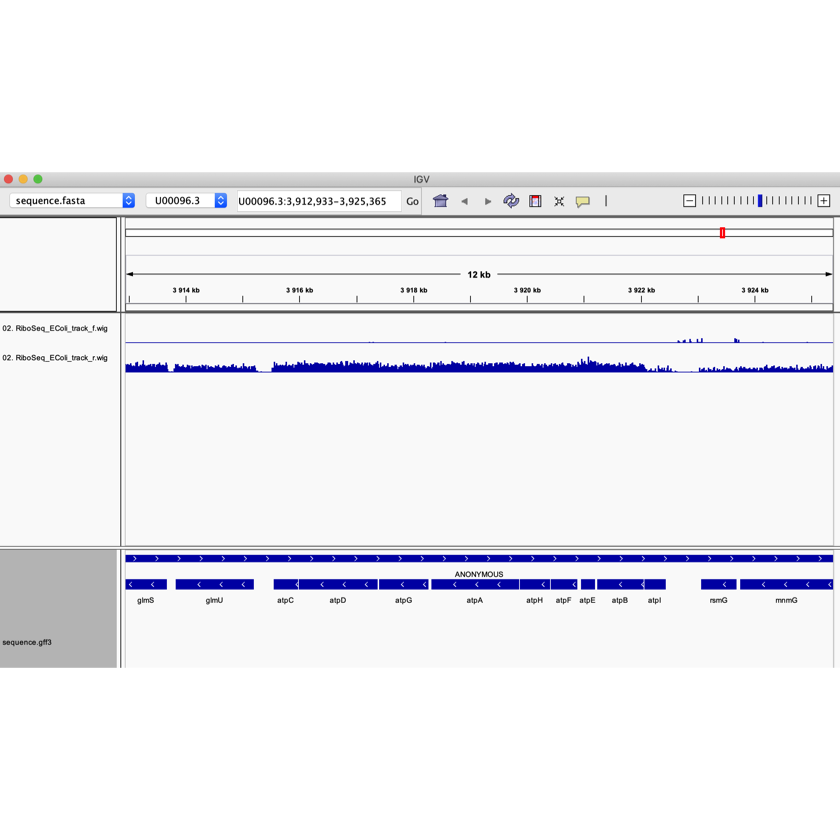

In [11]:
img <- readPNG('/users/vraip/Anaconda/ngs/hw_riboseq/pic3.PNG')
grid::grid.raster(img)

In [11]:
sapply(row.names(atp), function(x) {
    print(paste0(atp[x,]$gene, '  :  ',rpkm[x]))
})


[1] "atpC  :  2120.2874778548"
[1] "atpD  :  4681.22117104839"
[1] "atpG  :  1123.59326230441"
[1] "atpA  :  3649.71280070013"
[1] "atpH  :  1360.39914765828"
[1] "atpF  :  2063.89131619957"
[1] "atpE  :  22892.1238627238"
[1] "atpB  :  2159.07204145182"
[1] "atpI  :  103.21231955884"


7992                        7994 
 "atpC  :  2120.2874778548" "atpD  :  4681.22117104839" 
                       7996                        7998 
"atpG  :  1123.59326230441" "atpA  :  3649.71280070013" 
                       8000                        8002 
"atpH  :  1360.39914765828" "atpF  :  2063.89131619957" 
                       8004                        8006 
"atpE  :  22892.1238627238" "atpB  :  2159.07204145182" 
                       8008 
 "atpI  :  103.21231955884"

Разница между генами в опероне определенно есть. ВОзможно, это связано с размером или количеством субъединиц. На рисунке ниже видно, что нужно 10 субъединиц atpE, неудивительно, что именно для него самое высокое значение RPKM.


Не думаю, что эту разницу можно было бы увидеть на данных RNA-seq, так как у прокариот гены объединены в опероны, а RNA-seq у прокариот считываает транскрипты, так что весь оперон считался бы как один транскрипт. А после нормализации число прочтений во всех генах оперона было бы более или менее одинаковым.


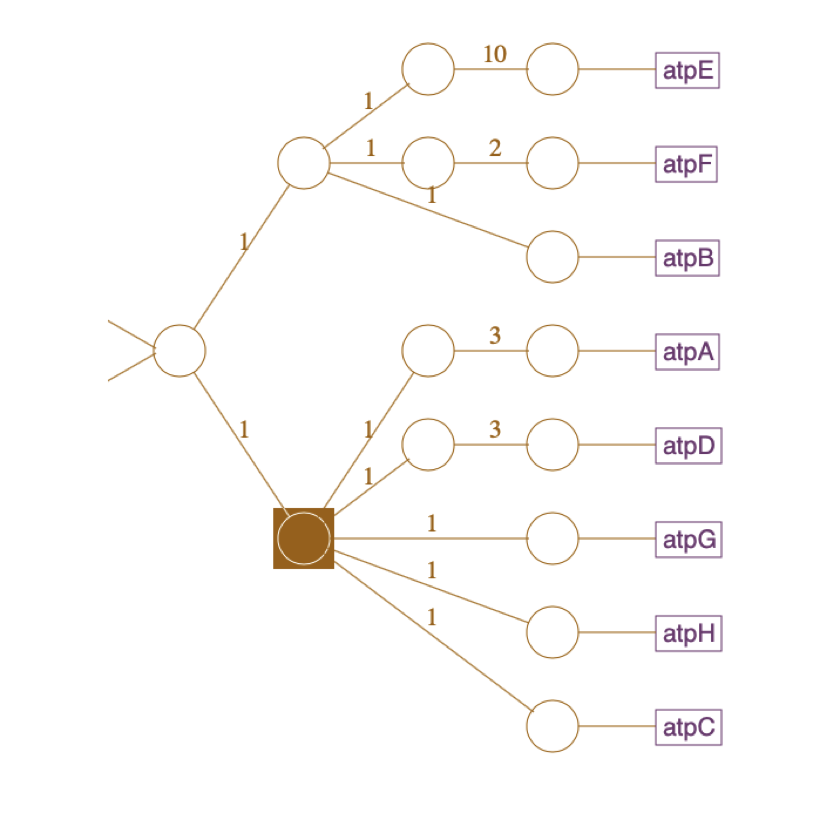

In [12]:
img <- readPNG('/users/vraip/Anaconda/ngs/hw_riboseq/pic4.PNG')
grid::grid.raster(img)